In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import hdbscan
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score, adjusted_rand_score
import seaborn as sns

import folium
import numpy as np
from IPython.display import display

In [2]:
full_df = pd.read_pickle('../../data/processed/state2/right_ios_df.pkl')
print(full_df.columns.tolist())

def assign_manual_label_3class(row):
    angle = row['gyroAngleChange']
    if angle < 60:
        return 0  # Lane Change
    elif angle < 140:
        return 1  # Left Turn
    else:
        return 2  # U-Turn

full_df['manual_label'] = full_df.apply(assign_manual_label_3class, axis=1)

print("Manual label distribution:")
print(full_df['manual_label'].value_counts().sort_index())
print()

print(full_df.columns.tolist())
features = [
    'angle_norm',                        
    'radius_log',                        
    'turn_intensity',                    
    'gyro_angular_change_per_second',   
    'eventDurationSeconds',            
]
df = full_df[features].copy()
print(df.columns.to_list())
print(df.shape)

['eventSampleSpeed', 'eventDurationSeconds', 'eventStartSpeed', 'eventEndSpeed', 'eventMilesDriven', 'memsMedianLateralAccel', 'gyro_angular_change_per_second', 'gyroAngleChange', 'mems_radius', 'aggressive', 'dv', 'turn_intensity', 'angle_norm', 'radius_log']
Manual label distribution:
manual_label
0    3837
1    8965
2     731
Name: count, dtype: int64

['eventSampleSpeed', 'eventDurationSeconds', 'eventStartSpeed', 'eventEndSpeed', 'eventMilesDriven', 'memsMedianLateralAccel', 'gyro_angular_change_per_second', 'gyroAngleChange', 'mems_radius', 'aggressive', 'dv', 'turn_intensity', 'angle_norm', 'radius_log', 'manual_label']
['angle_norm', 'radius_log', 'turn_intensity', 'gyro_angular_change_per_second', 'eventDurationSeconds']
(13533, 5)


/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_25459/1302670209.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


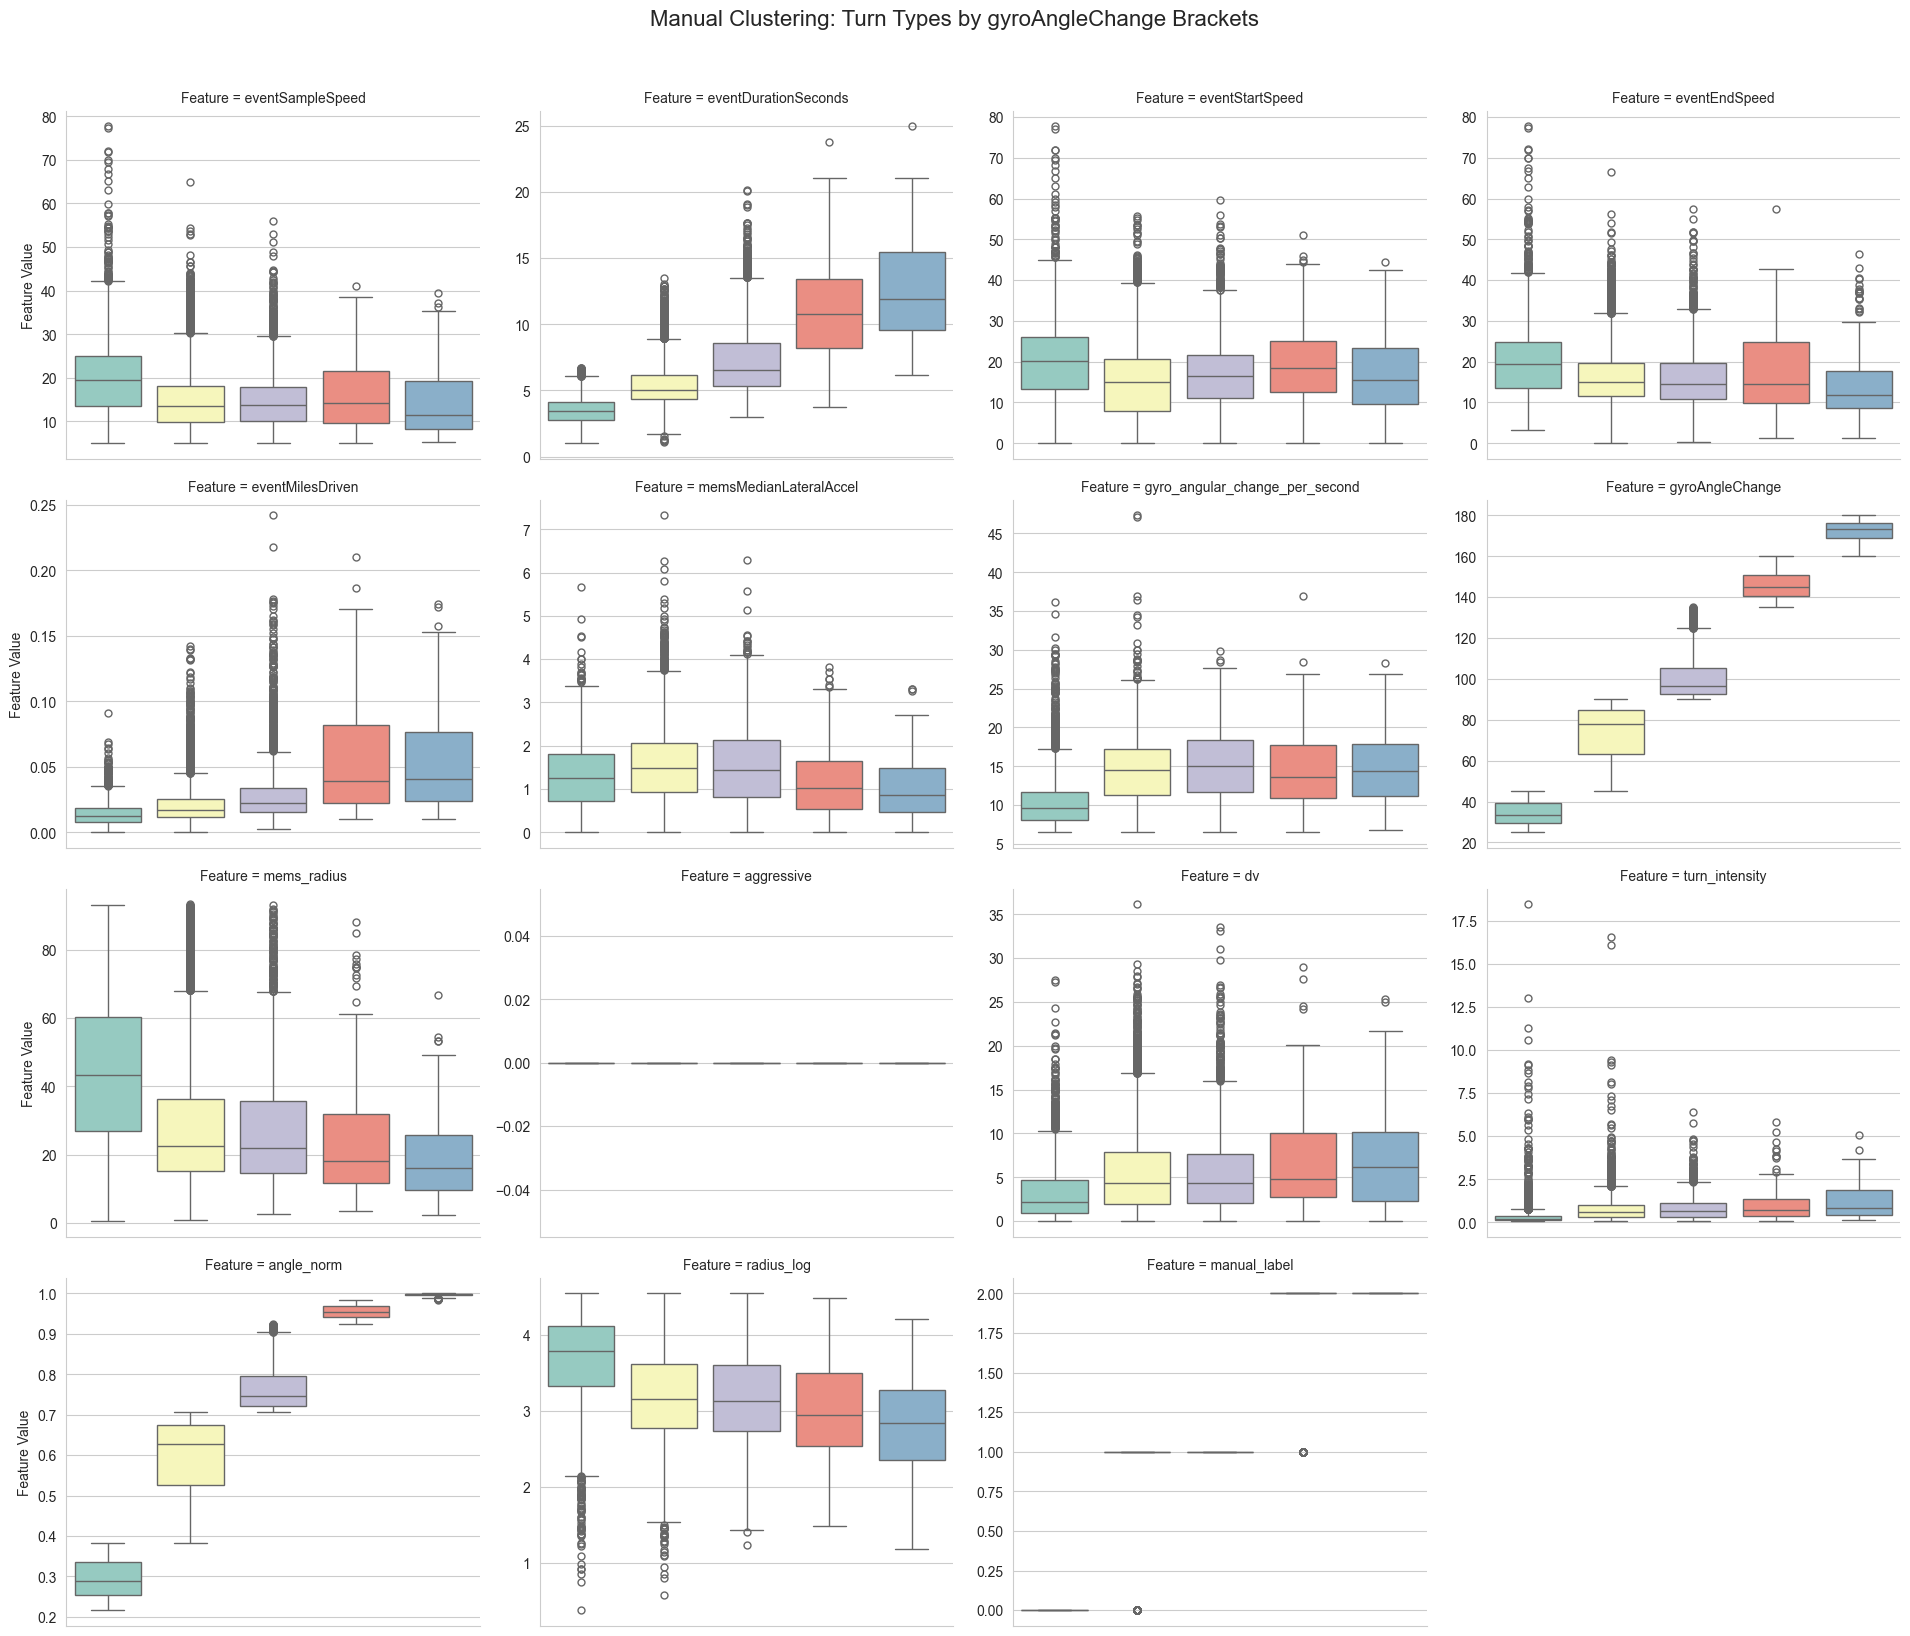


Sample counts per bracket:
Lane Change (0-45°): 2252
Gentle Turn (45-90°): 7877
Left Turn (90-135°): 2620
Sharp Turn (135-160°): 230
U-Turn (160-180°): 209


In [3]:
# Create different angle brackets (manual clustering)
brackets = {
    'Lane Change (0-45°)': full_df[full_df['gyroAngleChange'] <= 45].copy(),
    'Gentle Turn (45-90°)': full_df[(full_df['gyroAngleChange'] > 45) & (full_df['gyroAngleChange'] <= 90)].copy(),
    'Left Turn (90-135°)': full_df[(full_df['gyroAngleChange'] > 90) & (full_df['gyroAngleChange'] <= 135)].copy(),
    'Sharp Turn (135-160°)': full_df[(full_df['gyroAngleChange'] > 135) & (full_df['gyroAngleChange'] <= 160)].copy(),
    'U-Turn (160-180°)': full_df[(full_df['gyroAngleChange'] > 160) & (full_df['gyroAngleChange'] <= 180)].copy(),
}

# Combine all brackets
df_list = []
for bracket_name, df_bracket in brackets.items():
    df_bracket = df_bracket.copy()
    df_bracket['Turn_Type'] = f"{bracket_name}\n(n={len(df_bracket)})"
    df_list.append(df_bracket)

df_comparison = pd.concat(df_list, ignore_index=True)

# Get all numeric columnsn
melt_cols = df_comparison.select_dtypes(include=[np.number]).columns.tolist()

# Melt the dataframe
df_melted = df_comparison[['Turn_Type'] + melt_cols].melt(
    id_vars='Turn_Type',
    var_name='Feature', 
    value_name='Value'
)

# Plot
sns.set_style('whitegrid')
g = sns.catplot(
    data=df_melted,
    x='Turn_Type',
    y='Value',
    col='Feature',
    kind='box',
    col_wrap=4,
    palette='Set3',
    sharey=False,
    height=4,
    aspect=1.2
)

g.fig.suptitle(
    'Manual Clustering: Turn Types by gyroAngleChange Brackets', 
    y=1.02, 
    fontsize=16
)
g.set_axis_labels('', 'Feature Value')
g.set_xticklabels(rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.show()

# Print summary stats
print("\nSample counts per bracket:")
for name, df_bracket in brackets.items():
    print(f"{name}: {len(df_bracket)}")

In [4]:
def calculate_gini_score(labels) -> float:
    # Exclude HDBSCAN/DBSCAN noise
    labels = np.asarray(labels)
    mask = labels != -1
    if mask.sum() == 0:
        return 0.0
    # Counts per cluster
    counts = np.bincount(labels[mask])
    counts = counts[counts > 0].astype(float)
    if counts.size <= 1:
        return 0.0
    # Pairwise Gini
    G = np.abs(counts[:, None] - counts[None, :]).sum() / (2 * counts.size * counts.sum())
    # Normalize so 1.0 = maximally imbalanced given k clusters
    Gmax = (counts.size - 1) / counts.size
    return float(G / Gmax) if Gmax else 0.0

In [5]:
X_scaled = StandardScaler().fit_transform(df)
scaled_df = pd.DataFrame(X_scaled, columns=df.columns, index=df.index)
features_to_plot = features[:]   # keep plotting consistent with model inputs

In [6]:
# k means model
results_list = []
run_id = 0  # ← Add counter for tracking
run_labels = {}  # ✅ Store labels for plotting


# possible k values
for k in [2, 3, 4, 5]:
    kmeans_final = KMeans(n_clusters=k, random_state=42)
    kmeans_final.fit(X_scaled)
    final_labels = kmeans_final.labels_

    sil_score = silhouette_score(X_scaled, final_labels)
    noise_percentage = 0.0
    gini_score = calculate_gini_score(final_labels)
    ari_score = adjusted_rand_score(full_df['manual_label'], final_labels)  # ✅ Add ARI

    run_labels[run_id] = final_labels  # ✅ Store labels


    results_list.append({
        'run_id': run_id,  # ← Add this
        'model': 'kmeans',
        'sil. #': sil_score,
        'Gini': gini_score,
        'noise %': noise_percentage,
        'clust. #': k,
        'ARI': ari_score,  #Add ARI
    })
    run_id += 1  # ← Increment


In [7]:
N_total = X_scaled.shape[0]

In [8]:
# DBSCAN
for eps in np.linspace(0.1, 3.0, 20):
    for min_pts in range(8, 80):
        labels = DBSCAN(eps=float(eps), min_samples=int(min_pts), n_jobs=-1).fit_predict(X_scaled)
        mask = labels != -1
        labels_nn = labels[mask]
        n_clusters = len(np.unique(labels_nn)) if labels_nn.size > 0 else 0  # ← Fix
        n_noise = int((labels == -1).sum())
        noise_pct = (n_noise / N_total) * 100.0

        # ← Better edge case handling
        if n_clusters < 2 or n_clusters > 5 or labels_nn.size < 2:
            continue

        sil = silhouette_score(X_scaled[mask], labels_nn)
        gini = calculate_gini_score(labels)
        ari = adjusted_rand_score(full_df['manual_label'], labels)  # ✅ Add ARI

        run_labels[run_id] = labels  # ✅ Store labels


        results_list.append({
            'run_id': run_id,  # ← Add this
            'model': 'dbscan',
            'HP (eps)': float(eps),
            'HP (min_samp)': int(min_pts),
            'clust. #': int(n_clusters),
            'sil. #': float(sil),
            'Gini': float(gini),
            'noise %': float(noise_pct),
            'ARI': float(ari),  # ✅ Now ari is defined
        })
        run_id += 1  # ← Increment

In [9]:
# HDBSCAN
# Track which noise counts we've already seen for HDBSCAN
seen_noise_counts = set()

for min_samp in range(2, 30):
    for min_cluster_size in range(15, 80):

        # Optional: prune combos that tend not to help
        if min_samp > min_cluster_size:
            continue

        clusterer = hdbscan.HDBSCAN(
            min_samples=min_samp,
            min_cluster_size=min_cluster_size,
            metric='euclidean'
        )
        clusterer.fit(X_scaled)
        labels = clusterer.labels_

        non_noise_mask = labels != -1
        labels_non_noise = labels[non_noise_mask]
        n_non_noise = labels_non_noise.size
        n_clusters = len(np.unique(labels_non_noise)) if n_non_noise else 0

        n_noise = np.count_nonzero(labels == -1)
        noise_percentage = (n_noise / N_total) * 100.0

        # 🔹 Skip this run entirely if we've already seen this noise level
        if n_noise in seen_noise_counts:
            continue
        seen_noise_counts.add(n_noise)

        # ← Better filtering
        if n_clusters < 2 or n_clusters > 5:
            continue

        # Default
        sil_score = np.nan

        # Only try silhouette when it makes sense
        if noise_percentage < 15 and n_clusters >= 2 and n_non_noise >= 2:
            try:
                sil_score = silhouette_score(X_scaled[non_noise_mask], labels_non_noise)
            except ValueError:
                sil_score = np.nan

        gini_score = calculate_gini_score(labels)
        ari_score = adjusted_rand_score(full_df['manual_label'], labels)  # ✅ Add ARI

        run_labels[run_id] = labels  # ✅ Store labels

        results_list.append({
            'run_id': run_id,  # ← Add this
            'model': 'hdbscan',
            'HP (min_samp)': min_samp,
            'HP (min_clust)': min_cluster_size,
            'sil. #': sil_score,
            'Gini': gini_score,
            'noise %': noise_percentage,
            'clust. #': n_clusters,
            'ARI': ari_score,  # ✅ Add ARI

        })
        run_id += 1  # ← Increment

/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.14/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.14/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.14/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.14/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' 

In [10]:
results_df = pd.DataFrame(results_list)
results_df.head

<bound method NDFrame.head of      run_id    model    sil. #      Gini    noise %  clust. #       ARI  \
0         0   kmeans  0.336886  0.052095   0.000000         2  0.115864   
1         1   kmeans  0.356804  0.192492   0.000000         3  0.326525   
2         2   kmeans  0.323115  0.288751   0.000000         4  0.278350   
3         3   kmeans  0.322590  0.388753   0.000000         5  0.331752   
4         4   dbscan  0.742761  0.250859  99.283234         4 -0.008276   
..      ...      ...       ...       ...        ...       ...       ...   
219     219  hdbscan       NaN  0.861460  65.277470         3  0.039628   
220     220  hdbscan       NaN  0.584657  61.856203         2  0.079616   
221     221  hdbscan       NaN  0.589068  62.417794         2  0.074726   
222     222  hdbscan       NaN  0.587191  61.693638         2  0.080811   
223     223  hdbscan       NaN  0.572812  58.797015         2  0.106682   

     HP (eps)  HP (min_samp)  HP (min_clust)  
0         NaN         

In [11]:
results_df = pd.DataFrame(results_list).sort_values(
    by=['Gini', 'noise %', 'sil. #', 'clust. #'], 
    ascending=[True, True, False, False]
)

# Don't reset_index - you already have run_id in the data!
filtered_results = results_df.copy()

# Apply filters
filtered_results = filtered_results[filtered_results['noise %'] <= 15.0]
filtered_results = filtered_results[filtered_results['clust. #'].isin([3, 4])]
filtered_results = filtered_results[filtered_results['sil. #'] > 0.3]
filtered_results.head(100)

,run_id,model,sil. #,Gini,noise %,clust. #,ARI,HP (eps),HP (min_samp),HP (min_clust)
1,1,kmeans,0.356804,0.192492,0.000000,3,0.326525,NaN,NaN,NaN
2,2,kmeans,0.323115,0.288751,0.000000,4,0.278350,NaN,NaN,NaN
123,123,hdbscan,0.333736,0.986514,9.591369,3,0.155400,NaN,4.0,45.0
130,130,hdbscan,0.337350,0.986826,10.256410,3,0.155656,NaN,5.0,42.0
135,135,hdbscan,0.347863,0.988552,11.571714,3,0.161259,NaN,6.0,42.0
141,141,hdbscan,0.349848,0.989001,11.992906,3,0.166501,NaN,7.0,37.0
89,89,dbscan,0.310465,0.989077,5.963201,3,0.152749,0.557895,27.0,NaN
115,115,hdbscan,0.312004,0.990733,13.086529,3,0.175438,NaN,3.0,32.0
73,73,dbscan,0.323048,0.992837,13.345156,3,0.175909,0.405263,24.0,NaN
74,74,dbscan,0.325011,0.993242,13.625951,3,0.173476,0.405263,25.0,NaN


In [12]:
runs_to_plot = filtered_results['run_id'].head(5).tolist()
filtered_results = filtered_results.loc[filtered_results['run_id'].isin(runs_to_plot)]
filtered_results.head()

,run_id,model,sil. #,Gini,noise %,clust. #,ARI,HP (eps),HP (min_samp),HP (min_clust)
1,1,kmeans,0.356804,0.192492,0.000000,3,0.326525,NaN,NaN,NaN
2,2,kmeans,0.323115,0.288751,0.000000,4,0.278350,NaN,NaN,NaN
123,123,hdbscan,0.333736,0.986514,9.591369,3,0.155400,NaN,4.0,45.0
130,130,hdbscan,0.337350,0.986826,10.256410,3,0.155656,NaN,5.0,42.0
135,135,hdbscan,0.347863,0.988552,11.571714,3,0.161259,NaN,6.0,42.0


/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.14/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.14/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.14/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.14/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' 

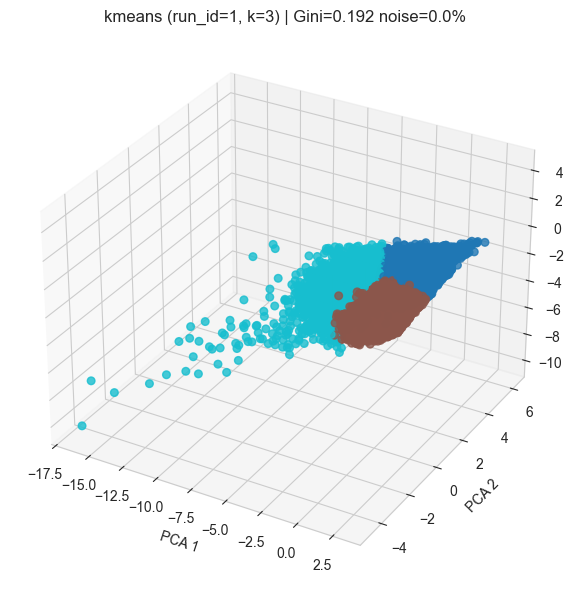

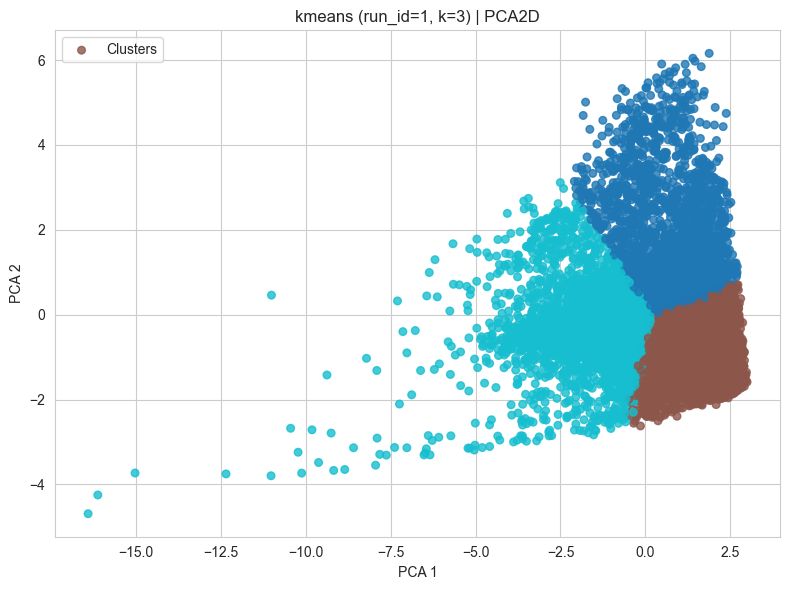

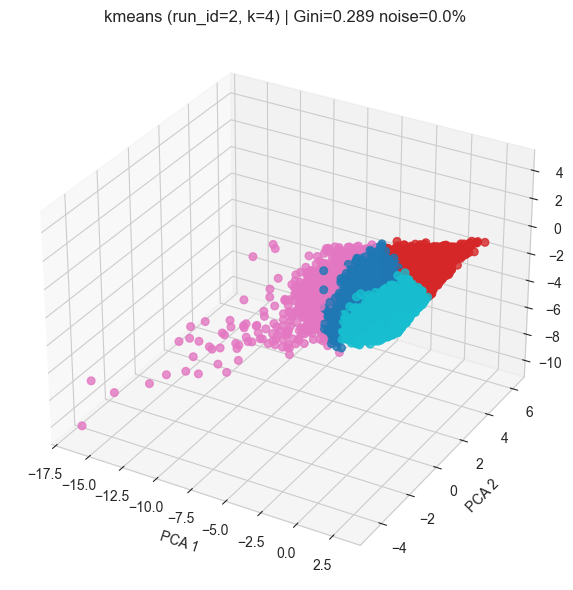

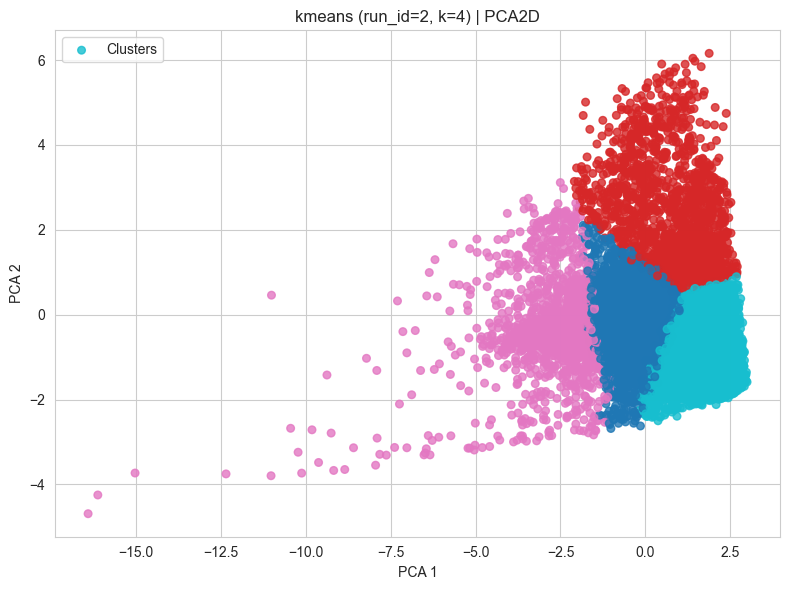

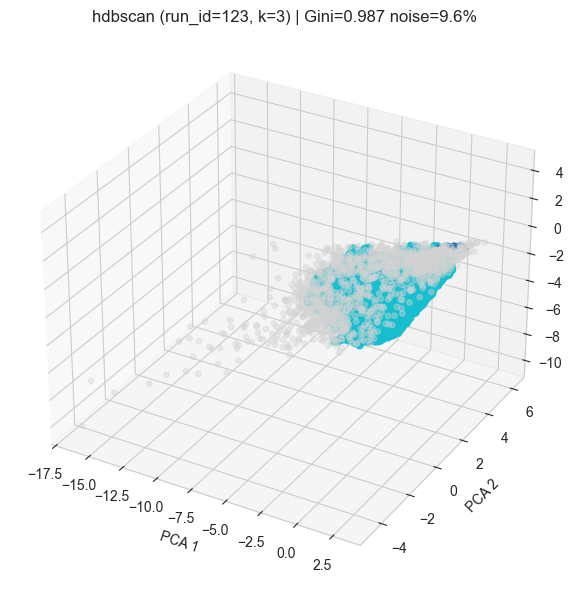

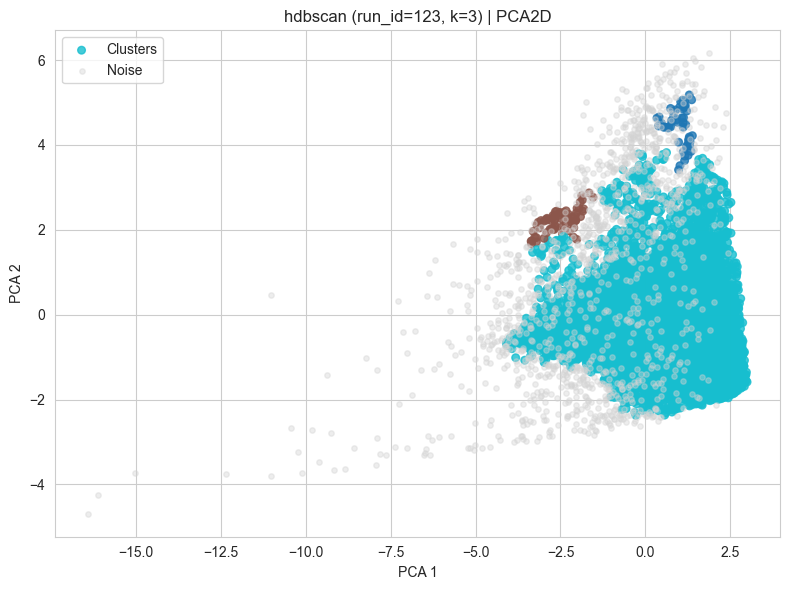

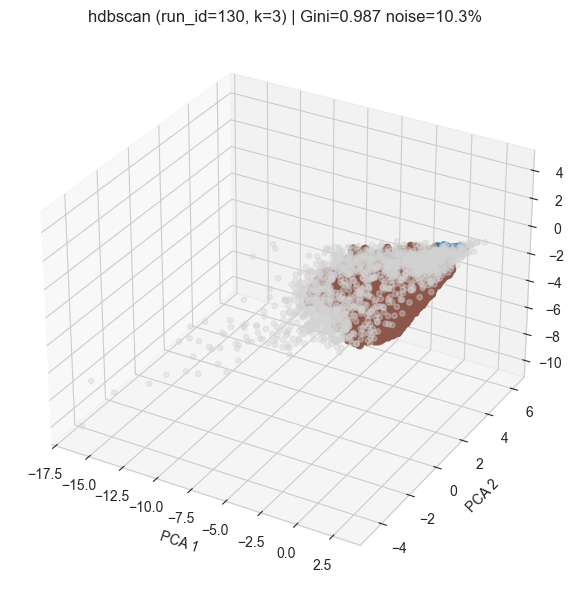

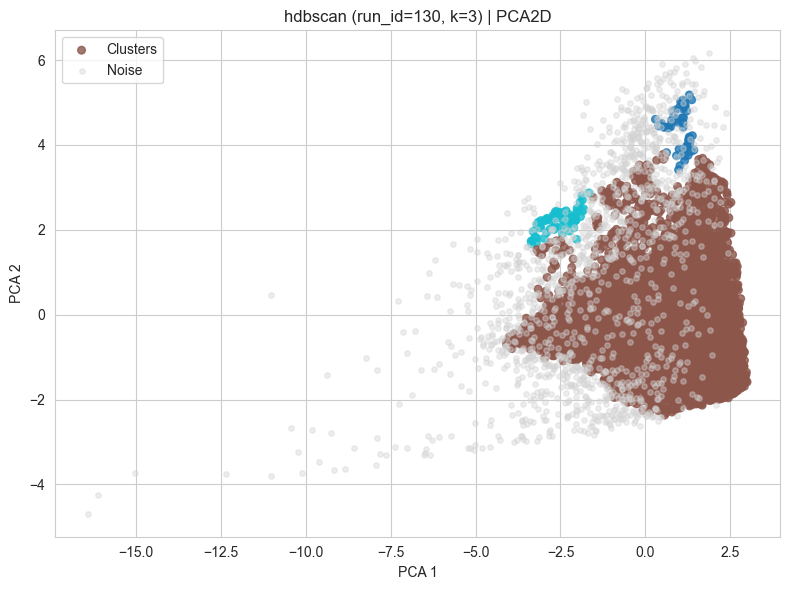

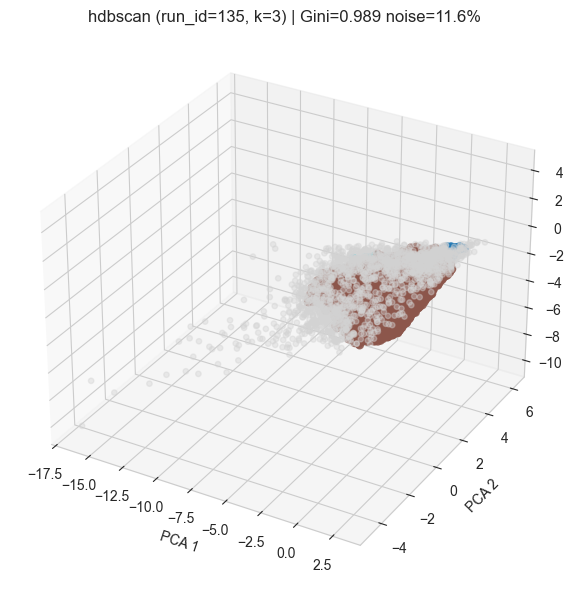

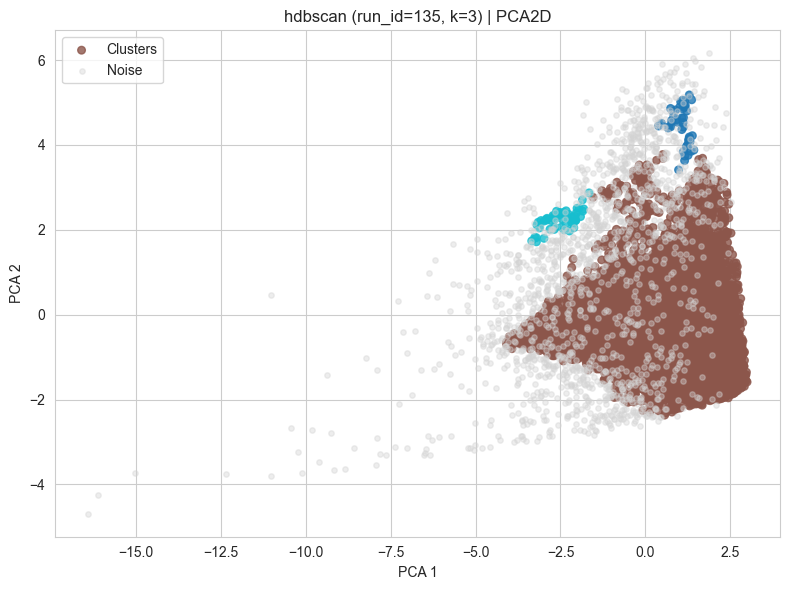

/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_25459/1539933878.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


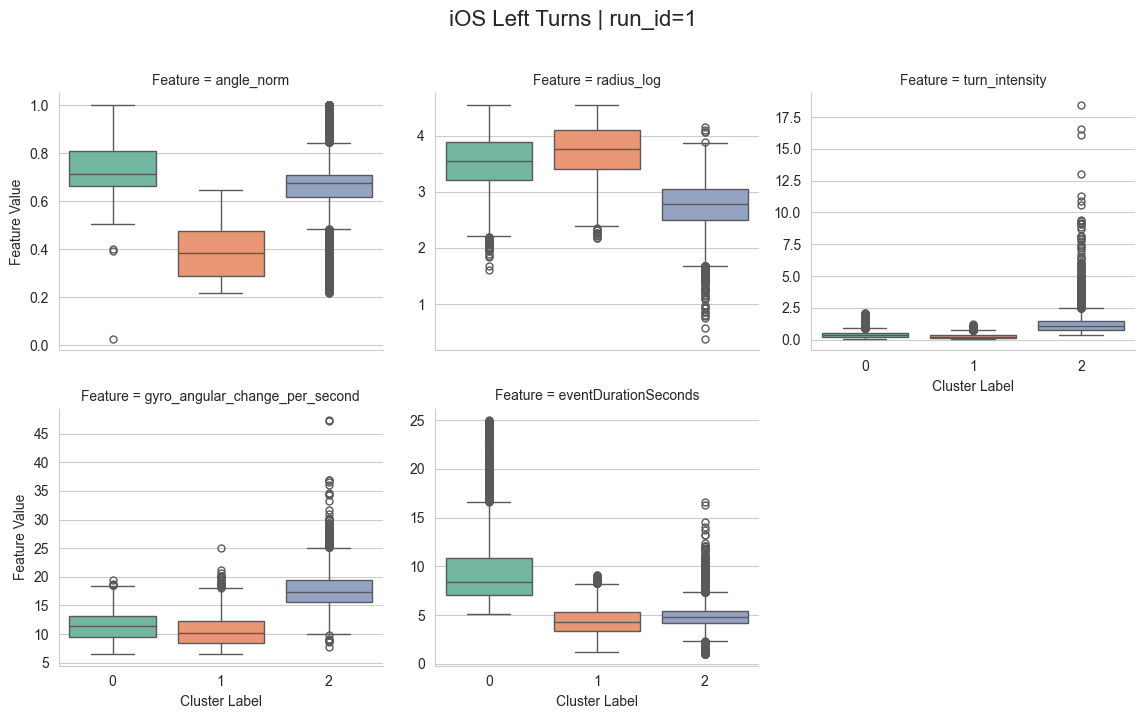

/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_25459/1539933878.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


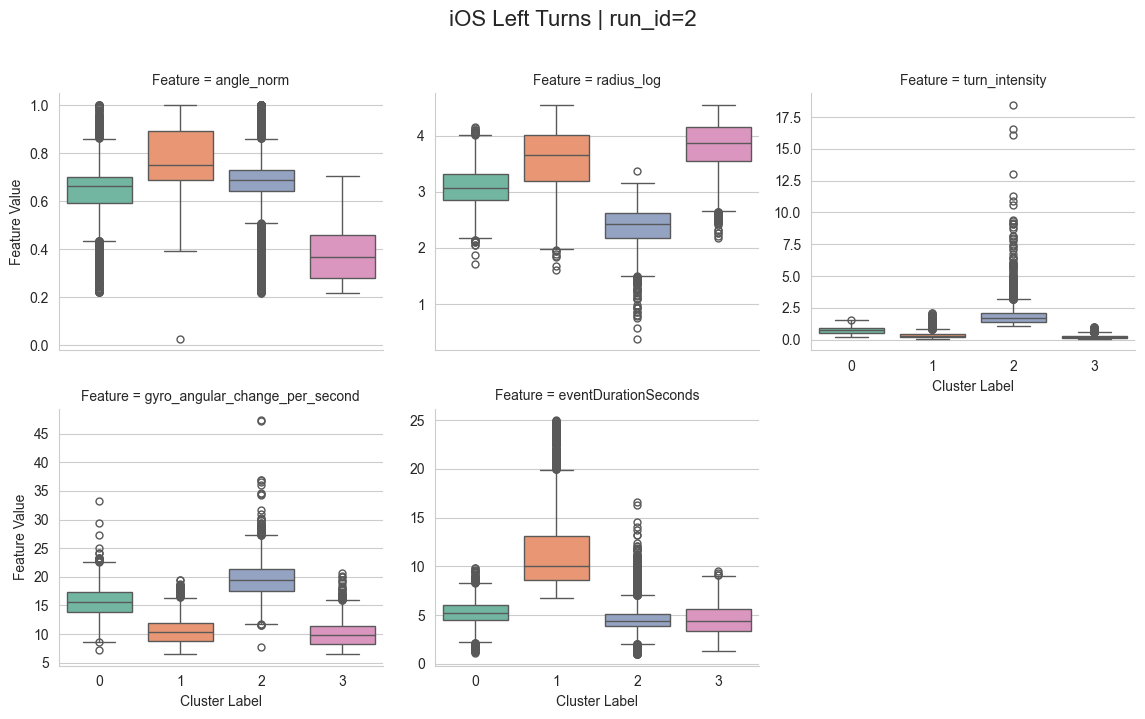

/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_25459/1539933878.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


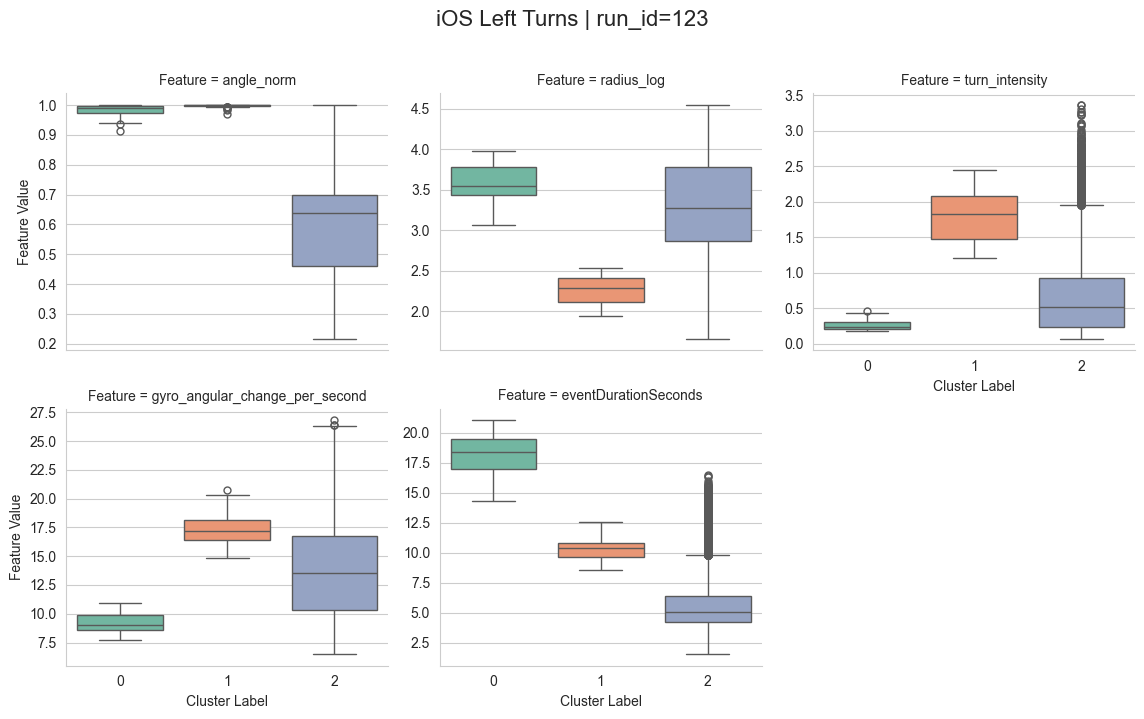

/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_25459/1539933878.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


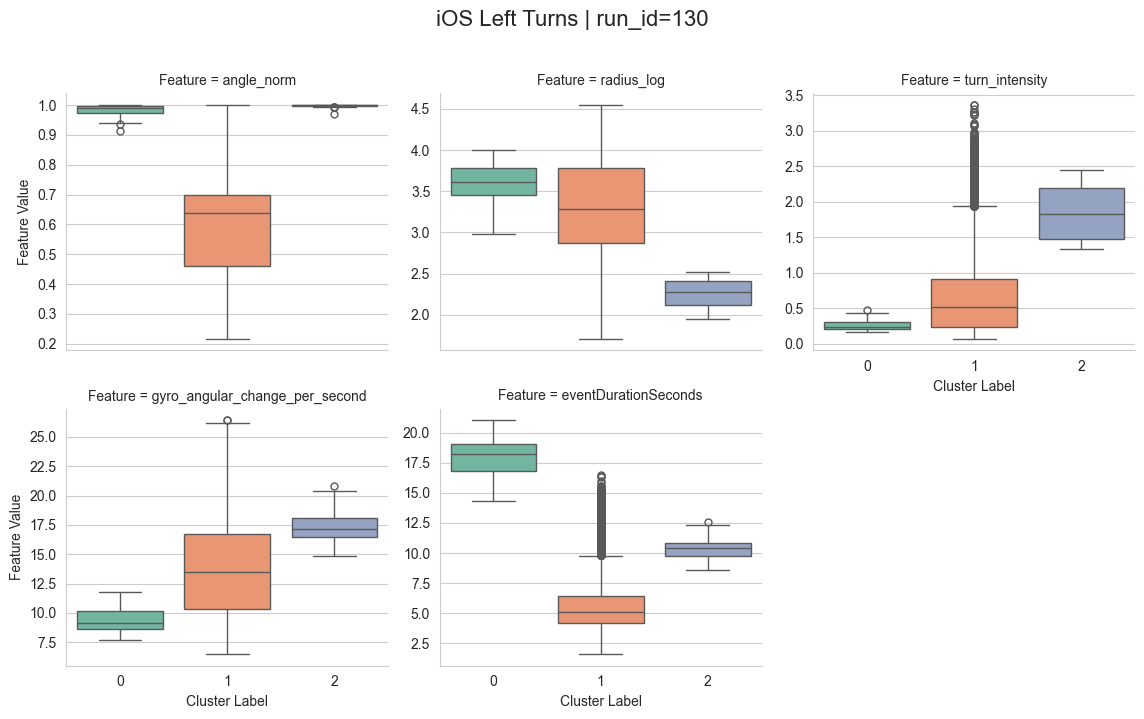

/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_25459/1539933878.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


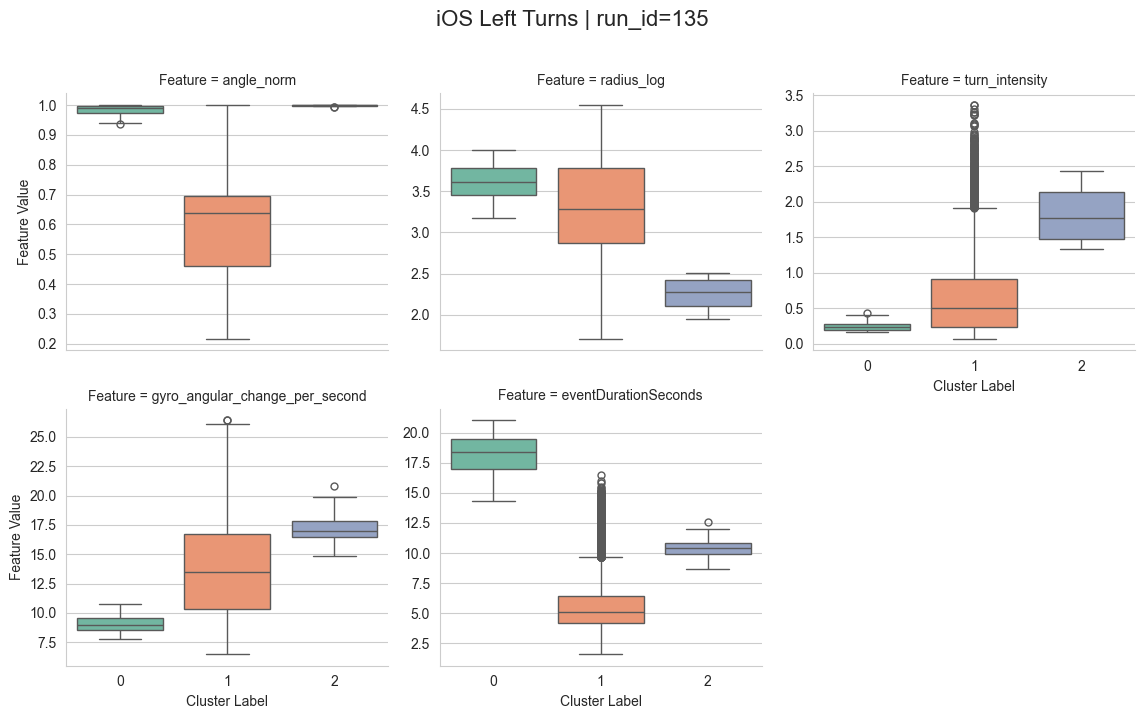

In [13]:
# --- CONFIG ---
plot_cols = features

# --- helpers ---------------------------------------------------------------
def build_clusterer(row):
    model = row['model']
    if model == 'kmeans':
        return KMeans(n_clusters=int(row['clust. #']), random_state=42)
    if model == 'dbscan':
        return DBSCAN(eps=float(row['HP (eps)']),
                      min_samples=int(row['HP (min_samp)']),
                      n_jobs=-1)
    if model == 'hdbscan':
        return hdbscan.HDBSCAN(min_samples=int(row['HP (min_samp)']),
                               min_cluster_size=int(row['HP (min_clust)'])
                               if pd.notna(row['HP (min_clust)']) else None)
    raise ValueError(f"Unknown model '{model}' for run_id {row['run_id']}")

def attach_clusters(labels):
    df_with_clusters = full_df.copy()
    df_with_clusters['Cluster_Label'] = labels
    return df_with_clusters[df_with_clusters['Cluster_Label'] != -1].copy()

# --- 1) filter the runs once -----------------------------------------------
runs = (
    filtered_results
    .loc[filtered_results['run_id'].isin(runs_to_plot)]
    .copy()
)
if runs.empty:
    raise ValueError(f"No rows found for run_id(s) {runs_to_plot}")

# fit each clusterer exactly once and cache its labels
run_labels = {}
for _, row in runs.iterrows():
    clusterer = build_clusterer(row)
    run_labels[row['run_id']] = clusterer.fit_predict(X_scaled)

# --- 2) PCA plots ----------------------------------------------------------
pca3 = PCA(n_components=3).fit_transform(X_scaled)
pca2 = PCA(n_components=2).fit_transform(X_scaled)

for _, row in runs.iterrows():
    run_id = row['run_id']
    labels = run_labels[run_id]
    core_mask = labels != -1
    noise_mask = labels == -1
    title_bits = f"{row['model']} (run_id={run_id}, k={row['clust. #']})"

    # 3D
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pca3[core_mask, 0], pca3[core_mask, 1], pca3[core_mask, 2],
               c=labels[core_mask], cmap='tab10', s=30, alpha=0.8)
    if noise_mask.any():
        ax.scatter(pca3[noise_mask, 0], pca3[noise_mask, 1], pca3[noise_mask, 2],
                   c='lightgray', s=15, alpha=0.4, label='Noise')
    ax.set_title(f"{title_bits} | Gini={row['Gini']:.3f} noise={row['noise %']:.1f}%")
    ax.set_xlabel('PCA 1'); ax.set_ylabel('PCA 2'); ax.set_zlabel('PCA 3')
    plt.tight_layout(); plt.show()

    # 2D
    plt.figure(figsize=(8, 6))
    plt.scatter(pca2[core_mask, 0], pca2[core_mask, 1],
                c=labels[core_mask], cmap='tab10', s=30, alpha=0.8, label='Clusters')
    if noise_mask.any():
        plt.scatter(pca2[noise_mask, 0], pca2[noise_mask, 1],
                    c='lightgray', s=15, alpha=0.4, label='Noise')
    plt.title(f"{title_bits} | PCA2D")
    plt.xlabel('PCA 1'); plt.ylabel('PCA 2'); plt.legend(); plt.tight_layout(); plt.show()

# --- 3) Box plots ----------------------------------------------------------
for _, row in runs.iterrows():
    run_id = row['run_id']
    labels = run_labels[run_id]
    df_plot = attach_clusters(labels)
    df_plot['Cluster_Label'] = df_plot['Cluster_Label'].astype('category')

    melt_cols = [c for c in plot_cols if c in df_plot.columns]
    if not melt_cols:
        raise ValueError("No overlap between plot_cols and df columns.")

    df_melted = df_plot[['Cluster_Label'] + melt_cols].melt(
        id_vars='Cluster_Label', var_name='Feature', value_name='Value'
    )

    sns.set_style('whitegrid')
    g = sns.catplot(
        data=df_melted,
        x='Cluster_Label',
        y='Value',
        col='Feature',
        kind='box',
        col_wrap=3,
        palette='Set2',
        sharey=False,
        height=3.5,
        aspect=1.1
    )
    g.fig.suptitle(f'iOS Left Turns | run_id={run_id}', y=1.02, fontsize=16)
    g.set_axis_labels('Cluster Label', 'Feature Value')
    plt.tight_layout()
    plt.show()


In [ ]:
# --- 1) pick which dataframe to use ---
df_with_clusters = full_df.copy()
df_with_clusters['Cluster_Label'] = labels

# pick which run to visualize
run_id = 2

# make sure you’re using the labels from that specific run
labels = run_labels[run_id]          # <--- CRUCIAL LINE

df_with_clusters = full_df.copy()
df_with_clusters['Cluster_Label'] = labels
assert 'Cluster_Label' in df_with_clusters.columns
assert 'Cluster_Label' in df_with_clusters.columns, "You need to attach cluster labels first."

# --- 2) drop noise and build pretty cluster labels with counts ---
df_plot = df_with_clusters[df_with_clusters['Cluster_Label'] != -1].copy()
counts = df_plot['Cluster_Label'].value_counts().sort_index()
label_map = {cl: f"{int(cl)} (n={int(counts.loc[cl])})" for cl in counts.index}
df_plot['Cluster_Str'] = df_plot['Cluster_Label'].map(label_map)

# keep a stable order on x-axis
ordered_xticks = [label_map[cl] for cl in sorted(counts.index)]
df_plot['Cluster_Str'] = pd.Categorical(df_plot['Cluster_Str'], categories=ordered_xticks, ordered=True)

# --- 3) select features to visualize (exclude IDs/GPS/labels) ---
excluded = {'Cluster_Label','Cluster_Str','eventStartLatitude','eventStartLongitude','eventEndLatitude','eventEndLongitude'}
features_to_plot = [c for c in df_plot.columns if c not in excluded and pd.api.types.is_numeric_dtype(df_plot[c])]

# --- 4) reshape to long form for seaborn ---
df_melted = df_plot.melt(
    id_vars='Cluster_Str',
    value_vars=features_to_plot,
    var_name='Feature',
    value_name='Value'
)

# --- 5) plot ---
sns.set(style='whitegrid')
g = sns.catplot(
    data=df_melted,
    x='Cluster_Str',
    y='Value',
    col='Feature',
    kind='box',
    col_wrap=3,
    height=3.5,
    aspect=1.2,
    sharey=False,
    palette='Set2'
)

k = len(counts)
g.fig.suptitle(f'Feature Distributions by Cluster (k={k}, run_id={run_id})', y=1.02, fontsize=16)
g.set_titles('Feature: {col_name}')
g.set_axis_labels('Cluster (n per cluster)', 'Feature Value')
plt.tight_layout()
plt.show()